In [59]:
import h5py
from clustering_methods import grassmannian_clustering_gruber2006
from tqdm import tqdm


<div style="text-align:center; font-size:24px;">Loading the eigenvects and clustering data using grassmann clustering</div>

In [60]:
# Only dealing with data from sleep_run-1 for each subject
# All data has sample size 429

cluster_numbers = [1, 2, 3, 4, 5, 6, 8, 10]
number_of_subjects = 33
obj_val_list = [] # list of lists, that hold the best objective function value for each number of clusters for each subject
subjects_missing_files = [] # some of the subjects dont have a sleep_run session
cluster_assignment_list = [] # list of list of lists, that hold the cluster assignment for each number of clusters for each subject

for subject in tqdm(range(1, number_of_subjects + 1)):
    subject = str(subject).zfill(2) # fill 01, 02 and so on

    try:
        with h5py.File(f"sleep_data/eigvecs/sub-{subject}_session-task-sleep_run-1_eigvecs.h5", "r") as file: # henter data
            data = file['eigvecs'][:]
    except FileNotFoundError:
        subjects_missing_files.append(subject)
        continue
    
    obj_vals = []
    cluster_assignments = []

    for cluster in cluster_numbers:
        C, part, obj = grassmannian_clustering_gruber2006(data, cluster, max_iter=100)
        obj_vals.append(obj)
        cluster_assignments.append(part)
    obj_val_list.append(obj_vals)
    cluster_assignment_list.append(cluster_assignments)

100%|██████████| 33/33 [28:21<00:00, 51.58s/it]


<div style="text-align:center; font-size:24px;">Using Objective Function Value as meassure for preformance</div>

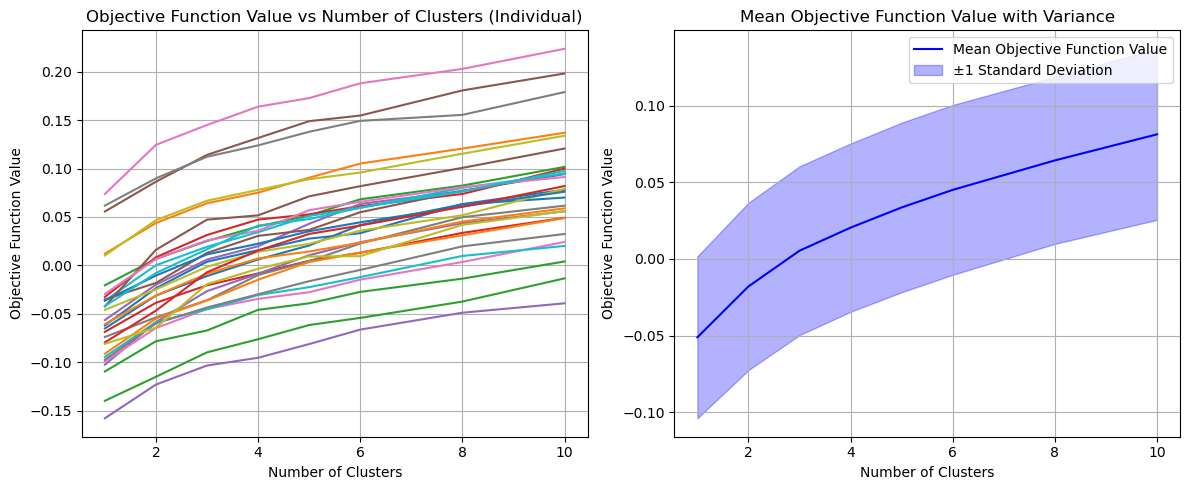

In [61]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure with (1, 2) subplot arrangement
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot individual objective function values
for idx, obj_vals in enumerate(obj_val_list):
    if str(idx + 1) not in subjects_missing_files: # skip subject if there where no file
        axes[0].plot(cluster_numbers, obj_vals, label=f"Subject {idx+1}")

# Compute mean and variance across subjects for each number of clusters
mean_values = np.mean(np.array(obj_val_list), axis=0)
variance_values = np.var(np.array(obj_val_list), axis=0)

axes[1].plot(cluster_numbers, mean_values, label='Mean Objective Function Value', color='blue')
axes[1].fill_between(cluster_numbers, mean_values - np.sqrt(variance_values), mean_values + np.sqrt(variance_values),
                     alpha=0.3, color='blue', label='±1 Standard Deviation')

# Add labels and title for subplot 1
axes[0].set_xlabel('Number of Clusters')
axes[0].set_ylabel('Objective Function Value')
axes[0].set_title('Objective Function Value vs Number of Clusters (Individual)')
axes[0].grid(True)

# Add labels and title for subplot 2
axes[1].set_xlabel('Number of Clusters')
axes[1].set_ylabel('Objective Function Value')
axes[1].set_title('Mean Objective Function Value with Variance')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


<div style="text-align:center; font-size:24px;">Using NMI as meassure for preformance</div>


In [62]:
import csv
import numpy as np

all_data_matrices = {} # lib to hold all the sleep_stage data for each subject
number_of_subjects = 33

for subject in tqdm(range(1, number_of_subjects + 1)):
    subject = str(subject).zfill(2) # fill 01, 02 and so on

    data_matrix = []
    
    with open(f"sleep_data/sleep_scores/sub-{subject}-sleep-stage.tsv", "r", newline="", encoding="utf-8") as tsv_file:
        tsv_reader = csv.reader(tsv_file, delimiter="\t")
        next(tsv_reader) # skip first row to remove column names
        for row in tsv_reader:
            if subject != "01":
                if row[0] == 'task-sleep_run-1': # Check if the row is 'task-sleep_run-1' for each subject
                    data_matrix.append(row)
            else:
                if row[1] == 'task-sleep_run-1': # Check if the row is 'task-sleep_run-1' for each subject
                    data_matrix.append(row)
    
    all_data_matrices[subject] = data_matrix

all_data_matrices["01"] = [row[1:] for row in all_data_matrices["01"]] # removing first collumn in data for subject "01" as it contains an extra collumn compared to the rest of the data

100%|██████████| 33/33 [00:00<00:00, 3586.55it/s]


In [63]:
# bud på en sequence til at fitte 30 sekund intervaller til 429 samples
# sums to 429
sequence = [14, 14, 14, 15, 14, 14, 14, 15, 14, 14, 15, 15, 14, 14, 14, 15, 14, 14, 14, 15, 14, 14, 15, 15, 14, 14, 14, 15, 14, 14]

# filter empty lists from subjects with no files
all_data_matrices = {subject: data_matrix for subject, data_matrix in all_data_matrices.items() if subject not in subjects_missing_files}


for subject in tqdm(range(1, number_of_subjects + 1)):
    subject = str(subject).zfill(2) # fill 01, 02 and so on
    if subject not in subjects_missing_files:
        repeated_data = np.repeat(np.array(all_data_matrices[subject])[:, 2], sequence)     
        all_data_matrices[subject] = repeated_data

100%|██████████| 33/33 [00:00<00:00, 19264.03it/s]


<div style="text-align:center; font-size:24px;">1 out of K encoding of the true labels</div>

In [64]:
number_of_sleep_stages = 3 # number of possible sleep_stages // we dont see any N = 3, so maybe we remove this?

possible_sleep_stages = ['W'] + [str(i) for i in range(1, number_of_sleep_stages)]

encoded_matrices = {} # new lib to keep 1 out of k encoded matrices

for subject, data_list in all_data_matrices.items():
    if subject not in subjects_missing_files: # we still make sure we dont deal with subjects we dont have data for
        subject_matrix = np.zeros((len(possible_sleep_stages), len(data_list)), dtype=int) # this will be (3, 429) as everything is right now
    
        for i, stage in enumerate(data_list): # Iterate over each sleep stage in the data list
            # Find the index of the stage in the possible_sleep_stages list
            try:
                stage_index = possible_sleep_stages.index(stage)
            except:
                stage_index = possible_sleep_stages.index(stage[0]) # here we take care of the data very we have '1 uncertain' or 'W uncertain'

            subject_matrix[stage_index, i] = 1 # Set the corresponding element in the subject_matrix to 1
        encoded_matrices[subject] = subject_matrix

<div style="text-align:center; font-size:24px;">1 out of K encoding of predicted labels using grassmann clustering</div>

In [97]:

encoded_predictions = {}
discount = 0

for idj, subject in enumerate(range(1, number_of_subjects + 1)):
    subject = str(subject).zfill(2)
    if subject in subjects_missing_files:
        discount += 1
        continue
    encoded_predictions[subject] = {}
    for idx, cluster in enumerate(cluster_numbers):
        possible_clusters = list(range(cluster))
        subject_matrix = np.zeros((cluster, len(cluster_assignment_list[idj-discount][idx])))
        for i, stage in enumerate(cluster_assignment_list[idj-discount][idx]):
            stage_index = possible_clusters.index(stage)
            subject_matrix[stage_index, i] = 1
        encoded_predictions[subject][cluster] = subject_matrix


<div style="text-align:center; font-size:24px;">Calculating NMI</div>

In [119]:
def calc_MI(Z1, Z2):
    P = Z1 @ Z2.T # joint probability matrix
    PXY = P / np.sum(P) # joint probability matrix normalized
    PXPY = np.outer(np.sum(PXY,axis=1),np.sum(PXY,axis=0)) # product of marginals
    ind = np.where(PXY > 0) # non-zero elements
    MI = np.sum(PXY[ind] * np.log(PXY[ind]/PXPY[ind])) # mutual information
    return MI

def calc_NMI(Z1, Z2):
    # Z1 and Z2 are two partition matrices of size (KxN) where K is number of components and N is number of samples

     ###### to handle runtime error
    if np.mean([calc_MI(Z1,Z1), calc_MI(Z2,Z2)]) == 0:
        return 0

    NMI = calc_MI(Z1,Z2) / np.mean([calc_MI(Z1,Z1), calc_MI(Z2,Z2)])

    return NMI


NMI_scores = []

for subject in range(1, number_of_subjects + 1):
    subject = str(subject).zfill(2)
    NMI_scores_subject = []
    if subject in subjects_missing_files:
        continue
    for cluster in cluster_numbers:
        score = calc_NMI(encoded_matrices[subject], encoded_predictions[subject][cluster])
        NMI_scores_subject.append(score)
    NMI_scores.append(NMI_scores_subject)


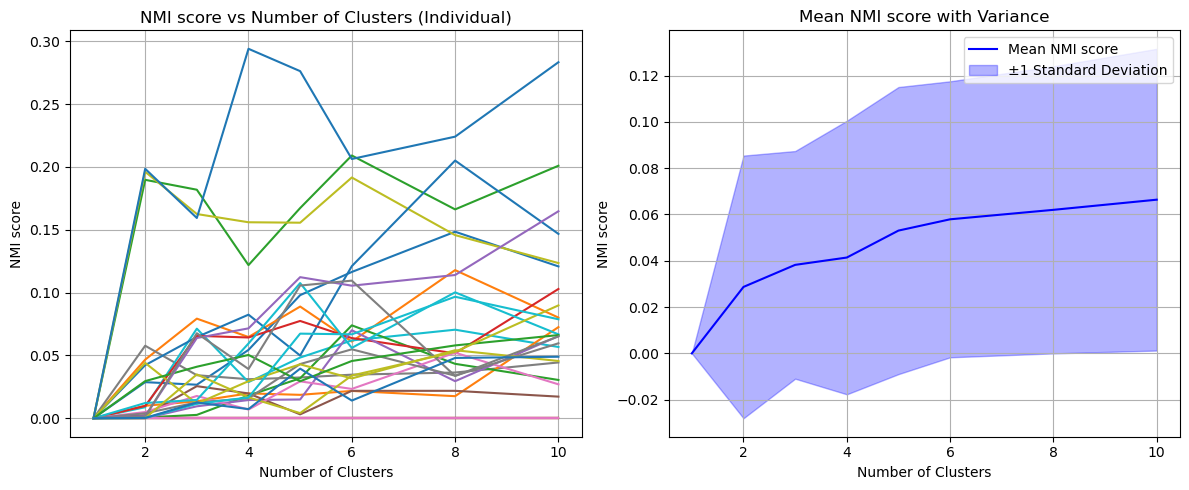

In [127]:
# Create a figure with (1, 2) subplot arrangement
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot individual objective function values
for idx, NMI_score in enumerate(NMI_scores):
    axes[0].plot(cluster_numbers, NMI_score)

# Compute mean and variance across subjects for each number of clusters
mean_values = np.mean(np.array(NMI_scores), axis=0)
variance_values = np.var(np.array(NMI_scores), axis=0)

axes[1].plot(cluster_numbers, mean_values, label='Mean NMI score', color='blue')
axes[1].fill_between(cluster_numbers, mean_values - np.sqrt(variance_values), mean_values + np.sqrt(variance_values),
                     alpha=0.3, color='blue', label='±1 Standard Deviation')

# Add labels and title for subplot 1
axes[0].set_xlabel('Number of Clusters')
axes[0].set_ylabel('NMI score')
axes[0].set_title('NMI score vs Number of Clusters (Individual)')
axes[0].grid(True)

# Add labels and title for subplot 2
axes[1].set_xlabel('Number of Clusters')
axes[1].set_ylabel('NMI score')
axes[1].set_title('Mean NMI score with Variance')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()